In [3]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests

In [4]:
!pip install -qU "langchain[mistralai]"

In [5]:
import getpass
import os
import google.colab.userdata

MISTRAL_API_KEY = google.colab.userdata.get('MISTRAL').strip()
if MISTRAL_API_KEY.startswith("Bearer "):
    MISTRAL_API_KEY = MISTRAL_API_KEY[len("Bearer "):]

from langchain.chat_models import init_chat_model

llm = init_chat_model("mistral-medium-latest", model_provider="mistralai", api_key = MISTRAL_API_KEY)

In [6]:
!pip install -qU langchain-mistralai

In [25]:
#embeddings
from langchain_mistralai import MistralAIEmbeddings



embeddings = MistralAIEmbeddings(model="mistral-embed", mistral_api_key=MISTRAL_API_KEY)

/usr/local/lib/python3.12/dist-packages/langchain_mistralai/embeddings.py:186: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [7]:
!pip install -qU langchain-core

In [9]:
#vectorstore (in memory)
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [10]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [11]:
from bs4 import BeautifulSoup, SoupStrainer
import requests

url = "https://www.gutenberg.org/cache/epub/13789/pg13789-images.html"
response = requests.get(url)

# Extract only paragraphs
only_p = SoupStrainer("p")
soup = BeautifulSoup(response.text, "html.parser", parse_only=only_p)

text = "\n".join(p.get_text() for p in soup.find_all("p"))
print(text[:500])  # first 500 chars


Title: Great Britain and the American Civil War
Author: Ephraim Douglass Adams
Release date: October 18, 2004 [eBook #13789]
                Most recently updated: October 28, 2024
Language: English
Credits: Produced by Jonathan Ingram, Charlie Kirschner and the PG Online
        Distributed Proofreading Team.

LORD JOHN RUSSELL
(From Trevelyan's "Garibaldi and the Making of Italy")
This work was begun many years ago. In 1908 I read in the
British Museum many newspapers and journals for the 


In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

# Wrap the scraped text in a Document
doc = Document(page_content=text)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents([doc])  # pass a list of Documents

print(len(all_splits))          # number of chunks
print(all_splits[0].page_content[:500])  # first 500 chars of first chunk


1257
Title: Great Britain and the American Civil War
Author: Ephraim Douglass Adams
Release date: October 18, 2004 [eBook #13789]
                Most recently updated: October 28, 2024
Language: English
Credits: Produced by Jonathan Ingram, Charlie Kirschner and the PG Online
        Distributed Proofreading Team.


In [13]:
# Index chunks
print(f"Using embeddings object: {embeddings}") # Print the embeddings object
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

Using embeddings object: client=<httpx.Client object at 0x7ea64965b140> async_client=<httpx.AsyncClient object at 0x7ea649af56d0> mistral_api_key=SecretStr('**********') endpoint='https://api.mistral.ai/v1/' max_retries=5 timeout=120 wait_time=30 max_concurrent_requests=64 tokenizer=<langchain_mistralai.embeddings.DummyTokenizer object at 0x7ea648a2e360> model='mistral-embed'


/usr/local/lib/python3.12/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [14]:

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [15]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [17]:
response = graph.invoke({"question": "When did the american civil war happen?"})
print(response["answer"])

The American Civil War took place from **1861 to 1865**, beginning after the Confederate attack on Fort Sumter in April 1861 and ending with the surrender of Confederate forces in 1865. The context mentions key events like the blockade proclamation in April 1861 and the war's progression through 1864. It was the deadliest conflict in U.S. history at the time.


In [18]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.12/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


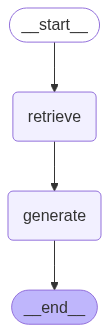

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
result = graph.invoke({"question": "how many people died during the american civil war?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='0f2ce697-b7b3-4921-a191-b7e6c988ca94', metadata={}, page_content='resumed an upward trend, increasing rapidly until December, 1862,\r\nwhen it reached its highest point of 284,418. In this same first\r\nweek of December private relief, now thoroughly organized in a\r\ngreat national effort, was extended to 236,000 people, making a\r\ngrand total at high tide of distress of over 550,000 persons, if\r\nprivate relief was not extended to those receiving public funds.\r\nBut of this differentiation there is no surety--indeed there are\r\nevidences of much duplication of effort in certain districts. In\r\ngeneral, however, these statistics do exhibit the great lack of\r\nemployment in a one-industry district heretofore enjoying unusual\r\nprosperity[680].\nThe manufacturing operative population of the district was\r\nestimated at between 500,000 and 600,000. At the time of greatest\r\ndistress some 412,000 of these were receiving either public or\r\nprivate aid, thoug